## histogram_map.ipynb

This notebook is meant to test whether the transformation I deviced in 11/27/17 can in principle make arbitrary initial histograms converge onto a desired histogram after repeated applications.

The transformation is the application of the weight kernel. The discretized Frobenius-Perron equation will be:
\begin{equation}
\rho_{n+1}(r_k) = \sum_{i=1}^M \rho_n(r_i) \delta \left[ r_k - F \left( N \sum_{j=1}^N \omega_{ss}(r_i,r_j)r_j \rho_n(r_j) \right) \right]
\end{equation}  
where $\delta$ is the discrete delta function.

The histogram map, however, may not come from the discretized Frobenius-Perron equation, which is not well suited to model continuous dynamics. In particular, it assumes that all the units in one bin are transfered at each time step, and they can be transfered to distant bins without 
travelling through the intermediate bins.  
To address this we use a histogram map where units can only be transfered between contiguous bins, and only one (or a few) at a time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

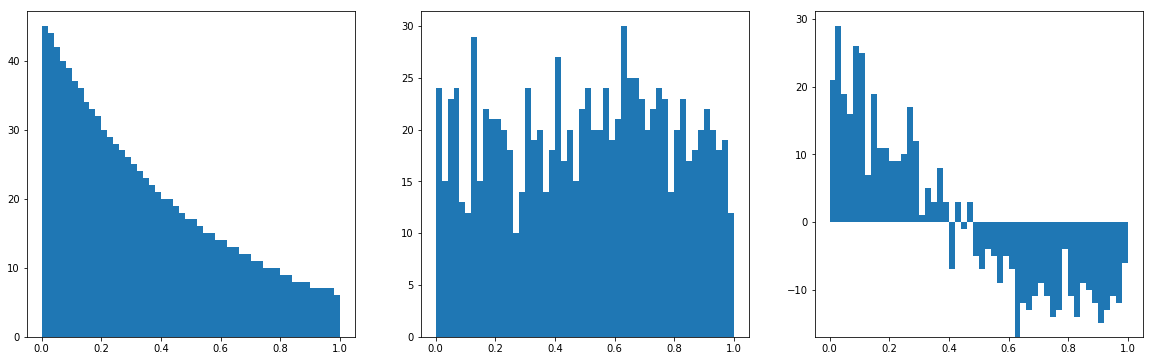

In [2]:
# Create the histograms
nbins = 50
n_units = 1000 # more units than bins
bin_edges = np.linspace(0,1,nbins+1) # bin edges
wid = bin_edges[1]-bin_edges[0]  # width of bins
bin_centers = ( bin_edges + (wid/2.) )[0:-1]

# the desired histogram has an exponential shape, parameter c
c = 2.
def exp_pdf(x):
    return ( c/(1.- np.exp(-c)) )* np.exp(-c*x)
exp_hist = np.array([int(round(wid*n_units*exp_pdf(x))) for x in bin_centers])
n_units = sum(exp_hist) # the discretization changes the number of units

# the initial histogram is random
def bin_number(x):
    return int( (x-1e-7) // wid )

rho = np.zeros(nbins)
while min(rho) < 1:
    for unit in range(n_units):
        rand_bin = bin_number(np.random.rand())
        rho[rand_bin] = rho[rand_bin] + 1
        
# the initial histogram is constant
#per_bin = int(n_units//nbins)
#remainder = n_units%nbins
#rho = np.tile(per_bin, nbins)
#rho[0] += remainder

#rho = exp_hist

hist_fig = plt.figure(figsize=(20,6))

exp_ax = hist_fig.add_subplot(1,3,1)
exp_ax.bar(bin_centers, exp_hist, wid, align='center')
init_ax = hist_fig.add_subplot(1,3,2)
init_ax.bar(bin_centers, rho, wid, align='center')
err_ax = hist_fig.add_subplot(1,3,3)
err_ax.bar(bin_centers, exp_hist-rho, wid, align='center')
plt.show()

In [3]:
# Initial definitions, utility functions
N = n_units
h = rho # the current histogram
r = bin_centers
M = nbins

def F(x):
    return 1./(1.+np.exp(-x))
    
    
def F_inv(x):
    return np.log(x/(1.-x))

u = F_inv(r)
crop_bin_edges = bin_edges
crop_bin_edges[0] = crop_bin_edges[0] + (.2/M)
crop_bin_edges[-1] = crop_bin_edges[-1] - (.2/M)
u_edges = F_inv(crop_bin_edges)
q = [ u_edges[i+1]-u_edges[i] for i in range(M) ]

def eq(a,b): # utility function to see if two 1-D arrays are equal
    for ai, bi in zip(a,b):
        if ai != bi:
            return False
    return True

def H(x): # The Heaviside step function. Applied to (x - 1e-8) so H(0) = 0
    return 0.5 * (np.sign(x-1e-8) + 1.)

def sgnm(x): # The sign function, but returns -1 for x==0
    return -1. if x == 0 else np.sign(x)
    """
    if x == 0:
        return np.random.choice([-1.,1.])
    else:
        return np.sign(x)
    """
    
def perm_matrix(N): # returns the circulant permutation matrix of order N in an numpy 2D array
    mat = np.zeros((N,N))
    row = np.zeros(N); row[0] = 1.
    for i in range(N):
        mat[i,:] = np.roll(row,i+1)
    return mat

def inv_perm_matrix(N): 
    # returns the inverse circulant permutation matrix of order N in an numpy 2D array
    mat = np.zeros((N,N))
    row = np.zeros(N); row[-1] = 1.
    for i in range(N):
        mat[i,:] = np.roll(row,i)
    return mat

# powers of the circulant permutation matrix
C0 = np.identity(M)
C1 = perm_matrix(M)
C2 = np.dot(C1,C1)
Cm1 = inv_perm_matrix(M) # inverse of C1
Cm2 = np.dot(Cm1,Cm1)    # inverse of C2
C_pow = (Cm2, Cm1, C0, C1, C2)

# Creating the matrices used for the rule with periodic boundaries
d_coeffs = [0., 0.5, -1., 0.5, 0]
dd_coeffs = [-0.5, 1., 0., -1., 0.5]
diff = np.zeros((M,M))  # matrix for the "diffusion" operation
diff_diff = np.zeros((M,M))  # matrix for the "difference of diffusions"
for m in range(5):
    diff += d_coeffs[m] * C_pow[m]
    diff_diff += dd_coeffs[m] * C_pow[m]
    

In [4]:
# Weight functions

def w_ss_free(i, j, mu, h):
    # The kernel for diffusion with free boundaries
    if i > 1 and i < M-2:
        delta = q[i] * sgnm( -0.5*h[i-2] + h[i-1] - h[i+1] + 0.5*h[i+2] ) * H( h[i] - 0.5*( h[i-1] + h[i+1] + 1) )
    elif i == 0:
        delta = q[i] * H( h[0] - h[1] )
    elif i == 1:
        delta = q[i]* sgnm( h[0] - 0.5*h[1] - h[2] + 0.5*h[3] ) * H( h[1] - .5*(h[0] + h[2] + 1) )
    elif i == M-2:
        delta = q[i] * sgnm( -0.5*h[M-4] + h[M-3] + 0.5*h[M-2] - h[M-1] ) * H( h[M-2] - .5*(h[M-3] + h[M-4] + 1) )
    elif i == M-1:
        delta = -q[i] * H( h[M-1] - h[M-2] )
    return (u[i] + delta) / mu
    
def w_ss_fixed(i, j, mu, h):
    # The kernel for diffusion with fixed boundary conditions
    # The kernel for diffusion with free boundaries
    left = 2 # int(round(M/3))  # desired number of units in the leftmost bin
    right = 10 # int(round(M/3))  # desired number of units in the rightmost bin
    D = np.dot(diff,h)
    if i > 1 and i < M-2:
        delta = q[i] * sgnm( -0.5*h[i-2] + h[i-1] - h[i+1] + 0.5*h[i+2] ) * H( -D[i]-0.5 )
    elif i == 0:
        delta = 5.*q[i] * H( h[0]-left )
    elif i == 1: 
        #delta = -q[i] * H( left-h[0] ) * H( -D[i]-0.5 ) # this bin is just servicing bin 0
        delta = q[i]* sgnm( h[0] - 0.5*h[1] - h[2] + 0.5*h[3] ) * H( h[1] - .5*(h[0] + h[2] + 1) )
    elif i == M-2: 
        #delta = q[i] * H( h[M-1]-right ) * H( -D[i]-0.5 ) # servicing bin M-1
        delta = q[i] * sgnm( -0.5*h[M-4] + h[M-3] + 0.5*h[M-2] - h[M-1] ) * H( h[M-2] - .5*(h[M-3] + h[M-4] + 1) )
    elif i == M-1:
        delta = -5.*q[i] * H( h[M-1]-right )
    return (u[i] + delta) / mu

def w_ss_circulant(i, j, mu, h):
    # The kernel for diffusion with periodic boundaries
    D = np.dot(diff,h)
    L = np.dot(diff_diff,h)
    delta = q[i] * sgnm(L[i]) * H(-D[i]-0.5)
    return (u[i] + delta) / mu


In [5]:
# Iterating function
#from IPython.core.debugger import set_trace
#from IPython.core.debugger import Tracer

def iterator(h, w_ss, n_iters=1):

    all_h = np.zeros((n_iters+1,M))
    h_n = h.copy()
    all_h[0,:] = h_n
    h_new = h_n  # array for the new histogram
    r_new = np.zeros(M)  # rates you'd get in steady state with the new histogram
    rwid = (r[1]-r[0])/2. # width of the bins in the rate histogram
    convergence = False # flag to indicate whether the histogram converged
    #set_trace()
    #Tracer()()
    
    for itr in range(n_iters):
        
        mu = sum(h_n * r)  # raw input coming to all cells 
        
        for i in range(M):  # calculate where the rates want to go due to inputs
            r_new[i] = F( sum( [w_ss(i, j, mu, h_n)*r[j]*h_n[j] for j in range(M)] ) )
    
        for k in range(M): # calculate new histogram
            if k > 1 and k < M-2: # general case
                ascending = H(r_new[k-1] - r[k-1] - rwid/2.) * H(h_new[k-1])  # receive a unit from bin k-1
                descending = H(r[k+1] - r_new[k+1] - rwid/2.) * H(h_new[k+1])  # receive a unit from bin k+1
                given = ( H(r_new[k] - r[k] - rwid/2.) + H(r[k] - r_new[k] - rwid/2.) ) * H(h_new[k])  # give a unit                
                h_new[k-1] -= ascending
                h_new[k+1] -= descending
                h_new[k] += ascending + descending - given
            elif k == 0: # first bin
                descending = H(r[k+1] - r_new[k+1] - rwid/2.) * H(h_new[k+1])  # receive a unit from bin k+1
                given = H(r_new[k] - r[k] - rwid/2.) *  H(h_new[k])
                h_new[k] += descending - given
            elif k == M-1: # last bin
                ascending = H(r_new[k-1] - r[k-1] - rwid/2.) * H(h_new[k-1])  # receive a unit from bin k-1
                given = H(r[k] - r_new[k] - rwid/2.) * H(h_new[k])
                h_new[k] += ascending - given
                
        h_n = h_new
    
        #print("this should be n_units: %f" % (sum(h_n)))
        all_h[itr+1,:] = h_n
        if eq(all_h[itr,:], all_h[itr+1,:]) and not convergence:
            print("Distribution converged at iteration %d" % (itr))
            convergence = True
            #break
    return all_h

Distribution converged at iteration 16


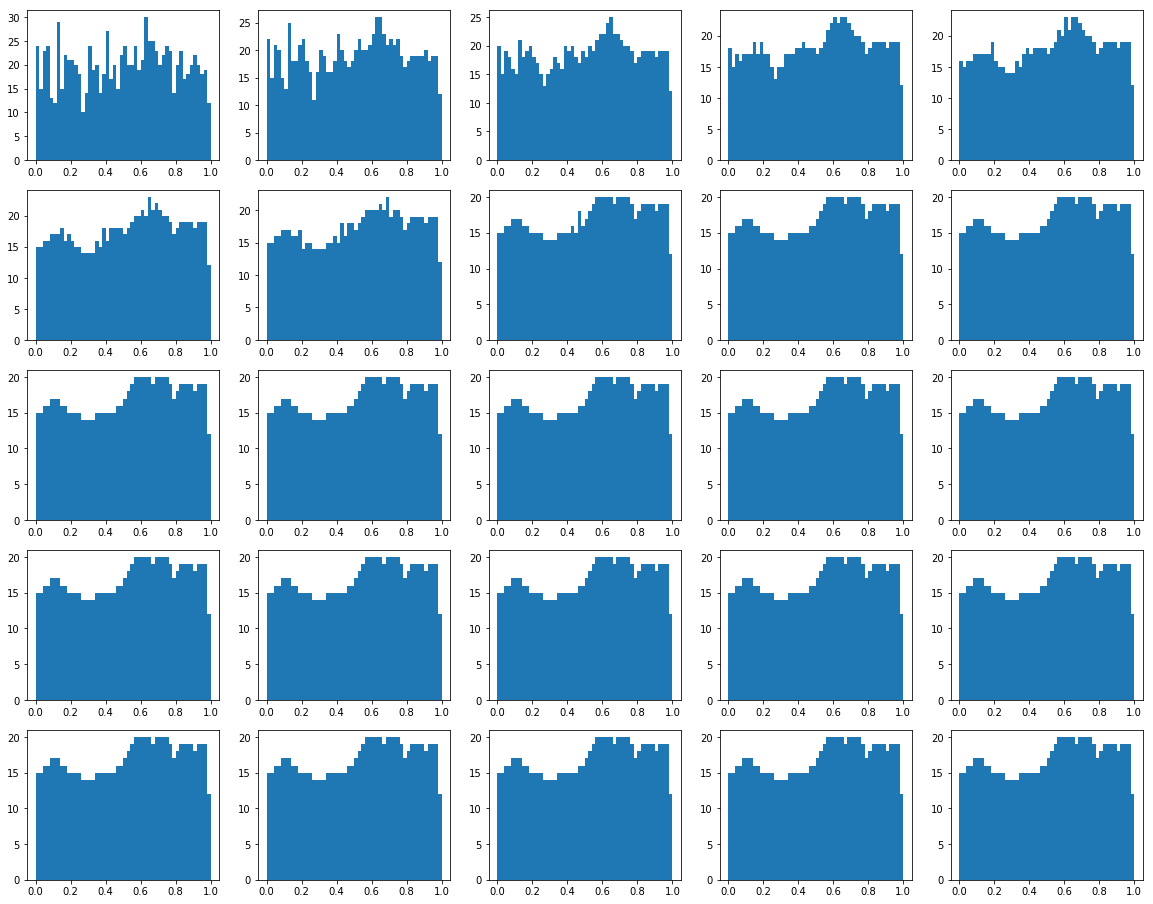

In [8]:
iters = 50
all_h = iterator(h, w_ss_free, n_iters=iters)
end_fig = plt.figure(figsize=(20,16))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = end_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, all_h[i*jump,:], wid, align='center')
    #ax.plot(r, rho_d, 'y')

"""
err_fig = plt.figure(figsize=(20,16))
jump = int(np.floor(iters/25))
for i in range(25):
    ax = err_fig.add_subplot(5,5,i+1)
    ax.bar(bin_centers, N*(rho_d - all_rho[i*jump,:]), wid, align='center')
"""
plt.show()

final h = 
[ 15.  15.  16.  16.  17.  17.  17.  16.  16.  15.  15.  15.  15.  14.  14.
  14.  14.  15.  15.  15.  15.  15.  15.  16.  16.  17.  18.  19.  20.  20.
  20.  20.  20.  19.  20.  20.  20.  20.  19.  17.  18.  19.  19.  19.  19.
  18.  19.  19.  19.  12.]


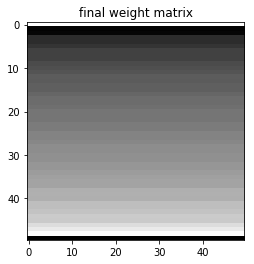

[-10.5   8.5  -3.5  -6.    5.    9.  -15.5  10.5  -4.    0.5  -0.5  -0.5
  -3.    6.    3.   -7.5   3.   -3.5   5.    2.5  -9.5   6.5  -4.    6.
  -2.5  -3.    2.    2.   -4.5   3.5   3.5  -7.    2.5  -1.   -0.5   2.5
   0.   -1.5  -4.    7.5  -1.5  -4.5   3.5   0.5   0.   -2.    0.    1.5
  -4.    9.5]


In [9]:
#print(n_units*(rho_d - all_rho[-1,:]))
h_final = all_h[-1,:]  # final histogram
print("final h = ")
print(h_final)
mu = sum(h_final * r)
# displaying weight matrix for the final histogram
w_mat = np.zeros((nbins, nbins))
for i in range(nbins):
    for j in range(nbins):
        w_mat[i,j] = w_ss_fixed(i,j,mu,h)
wfig, wax = plt.subplots()
wax.imshow(w_mat, cmap=plt.cm.gray, interpolation='nearest')
wax.set_title('final weight matrix')
plt.show()
#print(w_mat)
jumps = np.dot(diff,h) # diffusion filter applied to h
print(jumps)

In [10]:
len(diff)

50